In [2]:
import pandas as pd

# Carga el dataset
df = pd.read_csv(r"C:\Users\IALAB\Downloads\WESAD_TEST\features_30_025\features.csv", index_col=0)

# Ver las primeras filas
df.head()

HR_mean    HR_std  NN50      pNN50    TINN     rmsHRV          LF  \
0  64.801589  3.221112    10  31.250000  117.04  65.927135  237.661018   
1  64.801589  3.221112     9  29.032258  174.44  39.632478  254.501291   
2  64.735831  3.193327     9  28.125000  174.44  39.187720  285.073152   
3  65.246202  5.727747    10  31.250000   92.04  61.244618  285.081466   
4  64.634952  3.193486     9  29.032258  174.44  39.404737  296.372969   

           HF     LF_HF         sum_f  ...  Resp_I_std  Resp_E_mean  \
0  352.276097  0.674644  46826.927615  ...    0.905718     3.415250   
1  349.582217  0.728016  44458.918838  ...    0.899382     3.380625   
2  305.193957  0.934072  47337.111248  ...    0.850921     3.379625   
3  305.293177  0.933796  48441.191305  ...    0.720413     3.392625   
4  306.764986  0.966124  44724.698171  ...    0.721665     3.400375   

   Resp_E_std  Resp_IE_ratio  Resp_range  Resp_insp_vol  Resp_rate  \
0    0.929057       1.288534    5.012096       2.322209   0.233333   
1    0.889343       1.302225    4.968094       2.314259   0.233333   
2    0.877542       1.311043    4.917988       2.322618   0.233333   
3    0.877983       1.375690    4.984317       2.512205   0.200000   
4    0.883398       1.372378    5.057597       2.550288   0.200000   

   Resp_duration  subject  label  
0           30.0        4      1  
1           30.0        4      1  
2           30.0        4      1  
3           30.0        4      1  
4           30.0        4      1  

[5 rows x 54 columns]

In [18]:
# Dimensiones del dataset (filas, columnas)
print("Dimensiones:", df.shape)

# Tipos de datos
print(df.dtypes)

# Valores nulos
print("Valores nulos por columna:\n", df.isnull().sum())

# Conteo de clases (si hay una variable objetivo)
if 'label' in df.columns:
    print("Distribución de clases:\n", df['label'].value_counts())

Dimensiones: (160005, 54)
HR_mean          float64
HR_std           float64
NN50               int64
pNN50            float64
TINN             float64
rmsHRV           float64
LF               float64
HF               float64
LF_HF            float64
sum_f            float64
rel_f            float64
LF_norm          float64
HF_norm          float64
PPG_HR_mean      float64
PPG_HR_std       float64
PPG_RMSSD        float64
PPG_SDNN         float64
PPG_LF           float64
PPG_HF           float64
PPG_LF_HF        float64
PPG_num_beats      int64
PPG_RiseTime     float64
PPG_DecayTime    float64
PPG_PAV_mean     float64
PPG_PAV_std      float64
PPG_RI           float64
EDA_mean         float64
EDA_std          float64
EDA_min          float64
EDA_max          float64
EDA_range        float64
EDA_slope        float64
scl_mean         float64
scl_std          float64
scr_mean         float64
scr_std          float64
corr_scl_t       float64
scr_count          int64
scr_amp          float64

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
import os
import pickle
import cupy as cp
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as scisig
import scipy.stats
from scipy.interpolate import interp1d 
from collections import Counter
import scipy.interpolate as interp
import cupyx.scipy.signal as cusig
import neurokit2 as nk
from scipy.signal import find_peaks, welch, butter, filtfilt
from scipy.optimize import curve_fit
import cupyx.scipy.signal as cpysig
import gc
import psutil

Pruebas

In [260]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga el dataset
df = pd.read_csv(r"C:\Users\IALAB\Downloads\WESAD_TEST\dataProcessed\019-75424620.csv")

# Definir clases de interés
valid_labels = {1, 2, 3}

# Filtrar datos válidos
mask = df['label'].isin(valid_labels)

df = df[mask].reset_index(drop=True)
# Ver las primeras filas
df.columns

Index(['time', 'RESP', 'PPG', 'ECG', 'EDA', 'label'], dtype='object')

In [261]:
num_filas = df.shape[0]
fs = 1000
duracion = num_filas/fs
ventana = 30
stride = 0.75

n = (duracion-ventana)/stride
n = n+1
n = round(n)
print("habra " + str(n) + " ventanas de " + str(ventana * fs) + " datos")

habra 5054 ventanas de 30000 datos


In [262]:
filas = df['PPG'].shape[0]
print(filas)

3819883


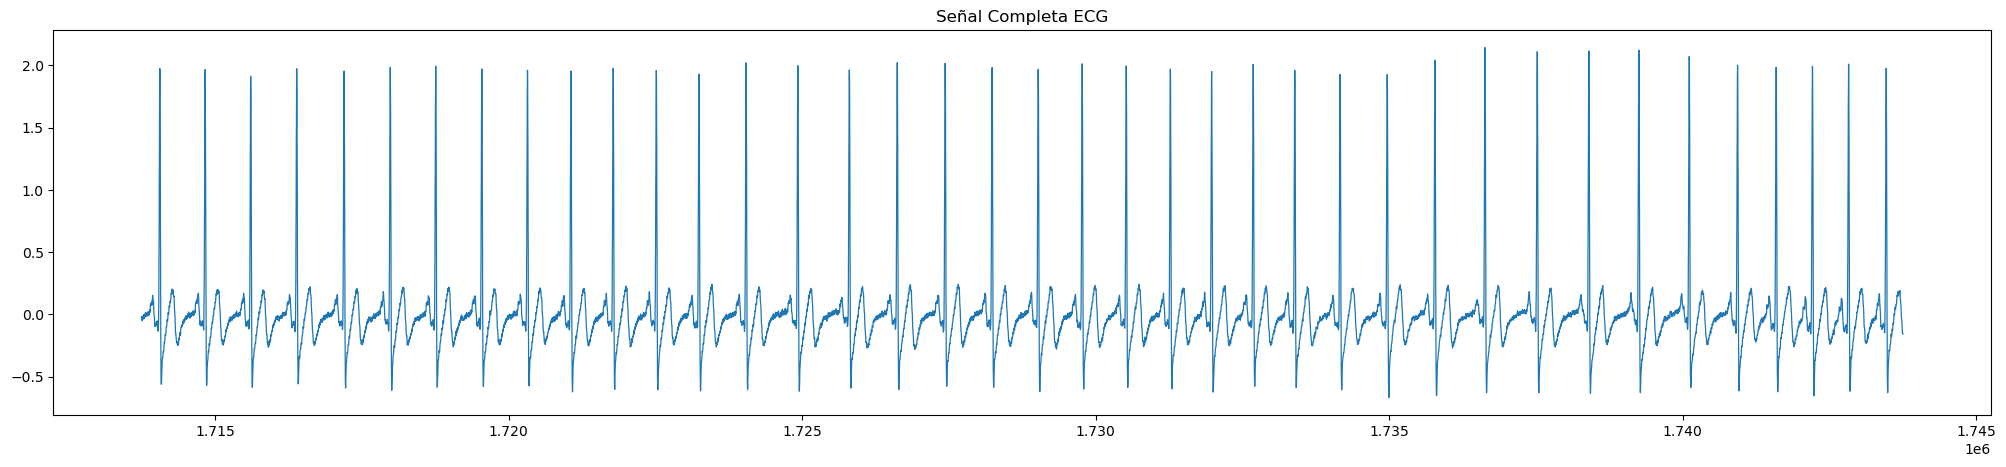

In [263]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(df['ECG'][1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa ECG")
plt.show()

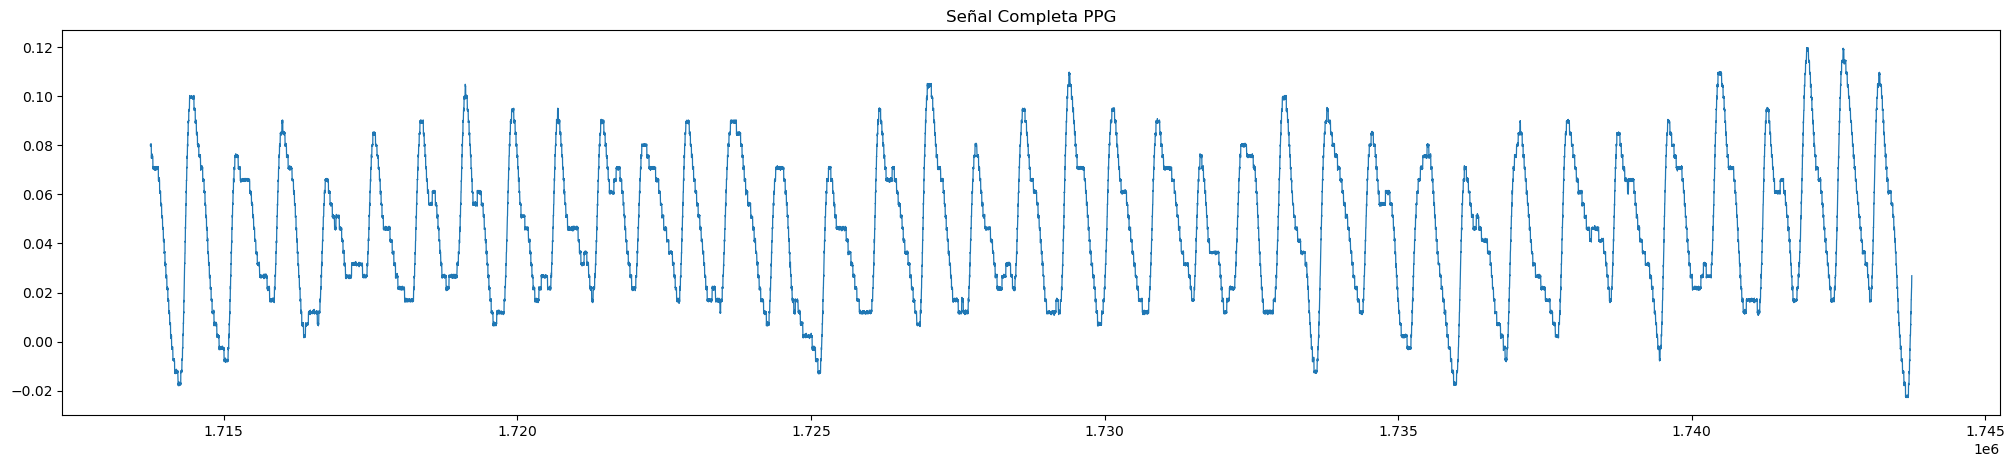

In [264]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(df['PPG'][1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa PPG")
plt.show()

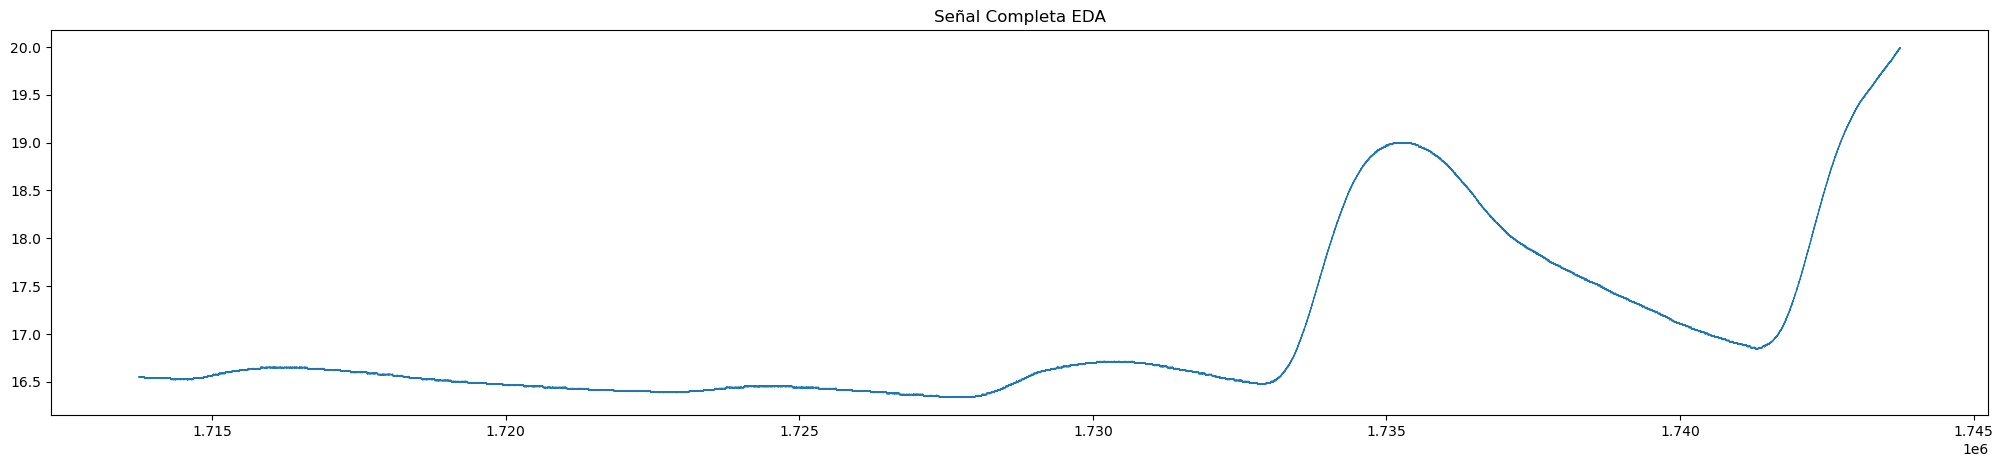

In [265]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(df['EDA'][1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa EDA")
plt.show()

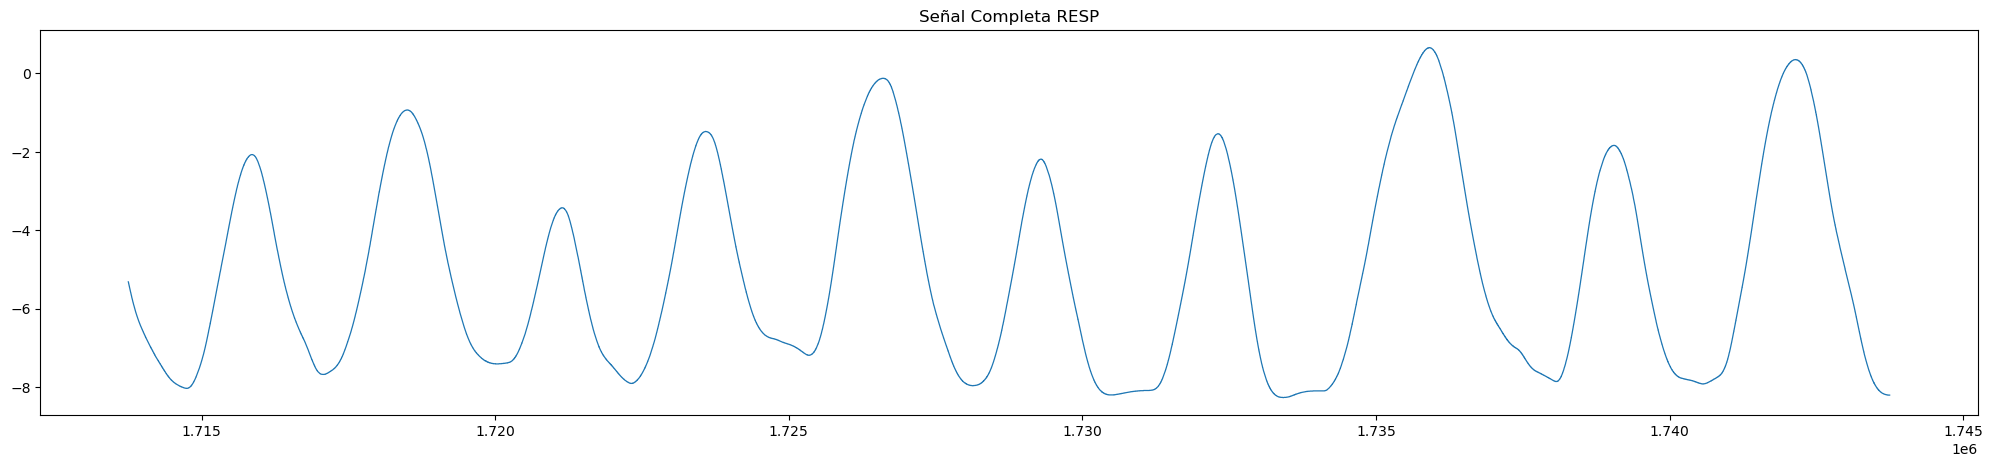

In [266]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(df['RESP'][1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa RESP")
plt.show()

In [267]:
def butter_filter(data, cutoff, fs, order=4, filter_type='low'):
    """
    Aplica un filtro Butterworth a los datos.

    Parámetros:
    - data: array de la señal a filtrar.
    - cutoff: frecuencia de corte (o tupla en caso de bandpass).
    - fs: frecuencia de muestreo.
    - order: orden del filtro.
    - filter_type: 'low', 'high' o 'band'.

    Retorna:
    - Señal filtrada.
    """
    nyq = 0.5 * fs  # Frecuencia de Nyquist

    # Normalizar la frecuencia de corte
    if isinstance(cutoff, (list, tuple)):  # Band-pass o Band-stop
        normal_cutoff = [c / nyq for c in cutoff]
    else:  # Low-pass o High-pass
        normal_cutoff = cutoff / nyq

    # Crear el filtro Butterworth
    b, a = scisig.butter(order, normal_cutoff, btype=filter_type, analog=False)

    # Aplicar el filtro con filtfilt para evitar desfases
    return scisig.filtfilt(b, a, np.array(data))

In [268]:
ecg_signal = butter_filter(df['ECG'], cutoff=(0.5, 40), fs=fs, order=4, filter_type='band')
ppg_signal = butter_filter(df['PPG'], cutoff=(0.5, 8), fs=fs, order=2, filter_type='band')
eda_signal = butter_filter(df['EDA'], cutoff=1, fs=fs, order=4, filter_type='low')
resp_signal = butter_filter(df['RESP'], cutoff=0.5, fs=fs, order=4, filter_type='low')

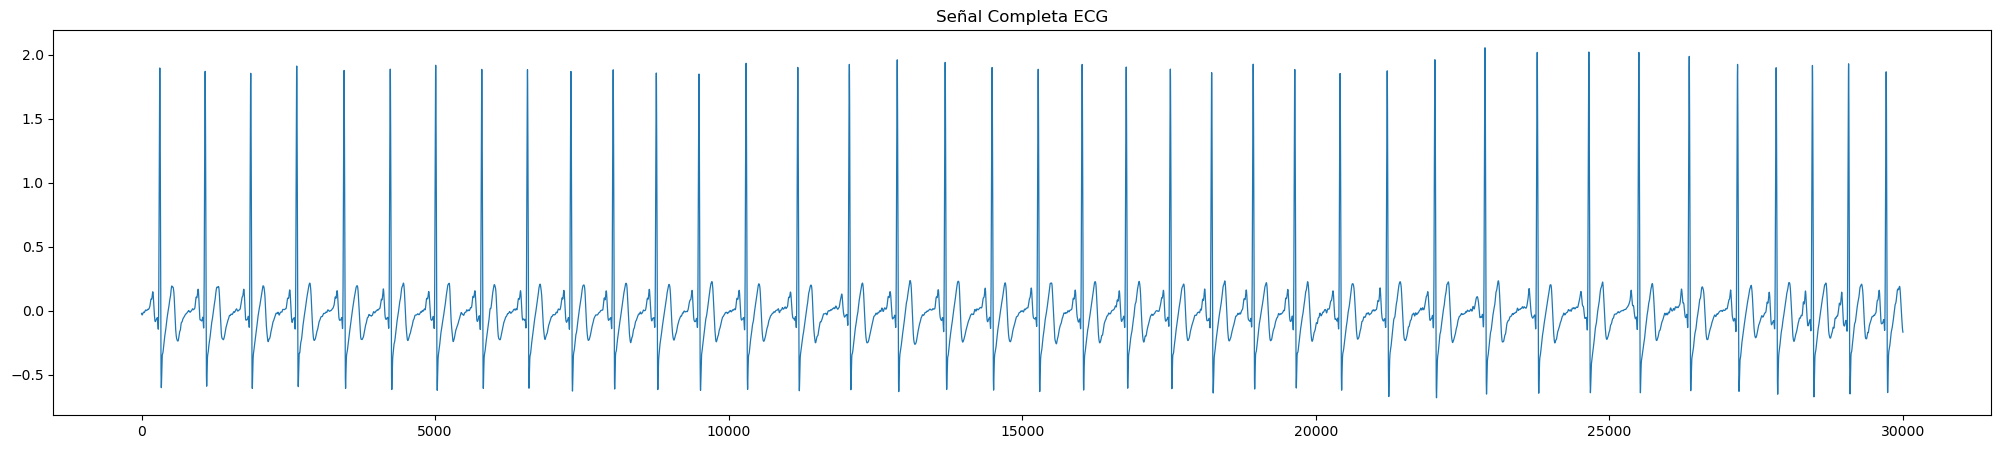

In [269]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(ecg_signal[1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa ECG")
plt.show()

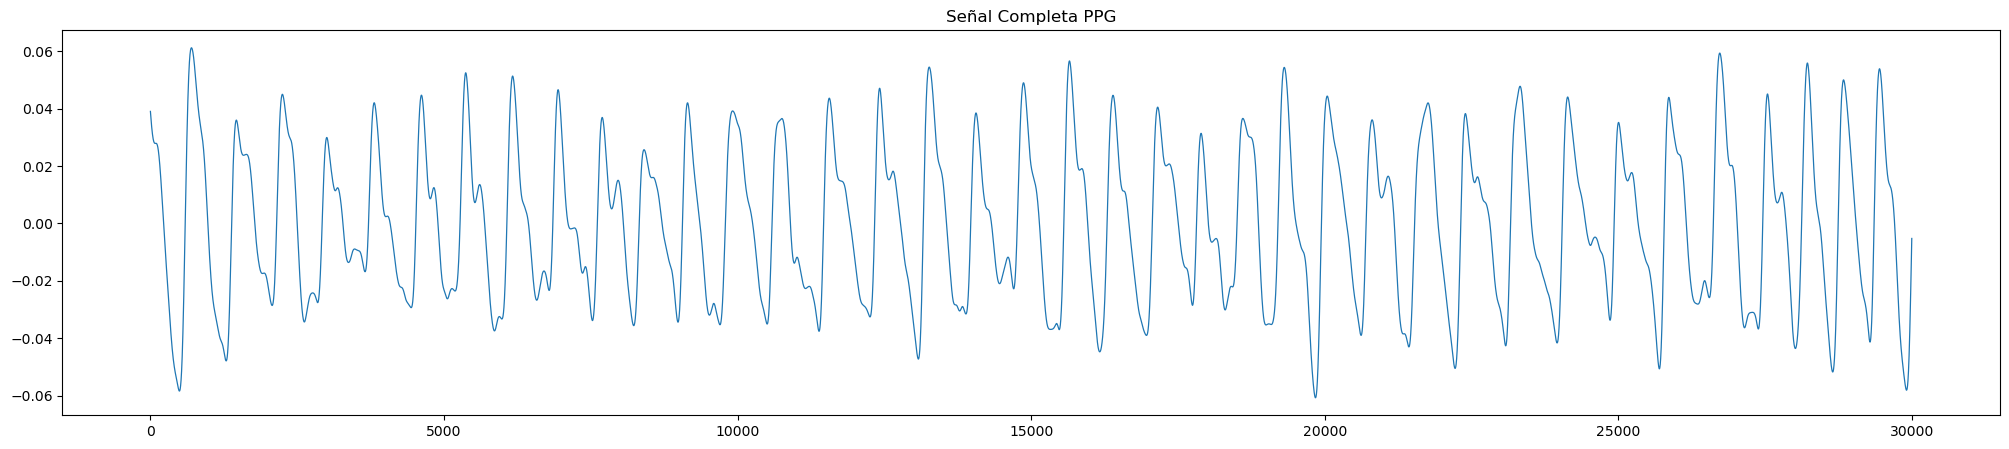

In [270]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(ppg_signal[1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa PPG")
plt.show()

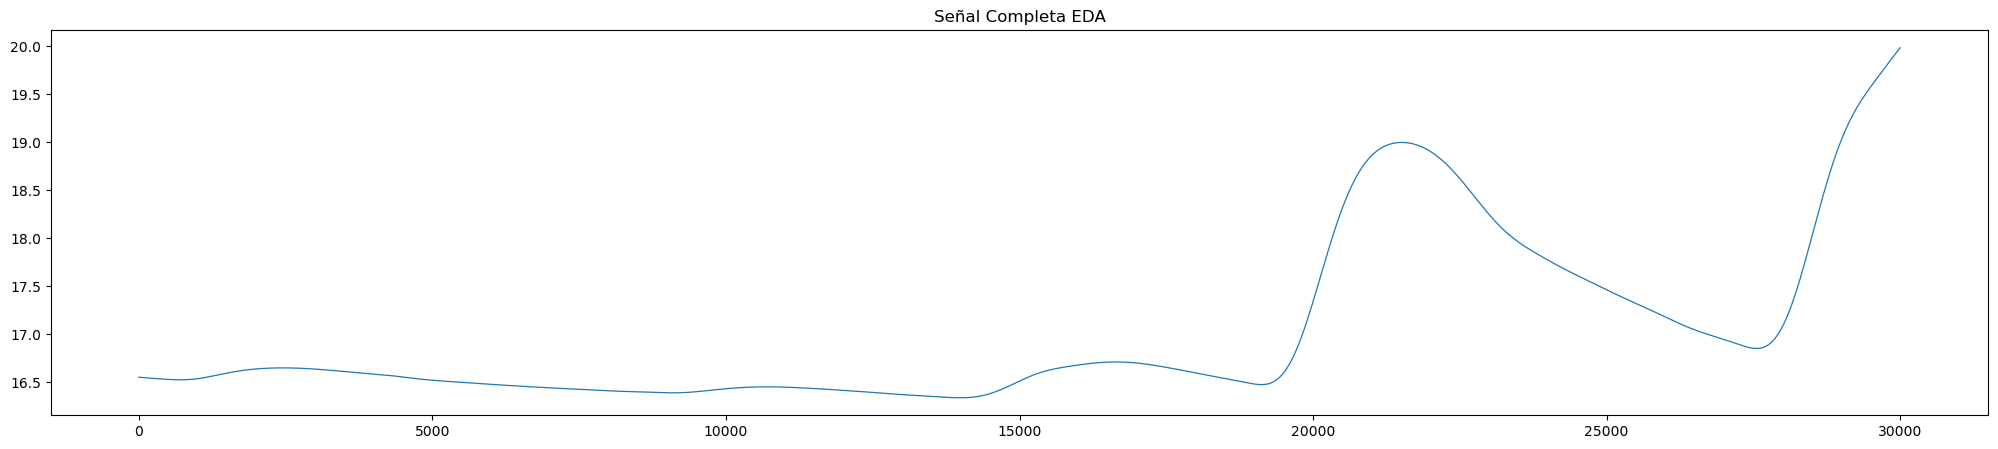

In [271]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(eda_signal[1713750:1743750], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa EDA")
plt.show()

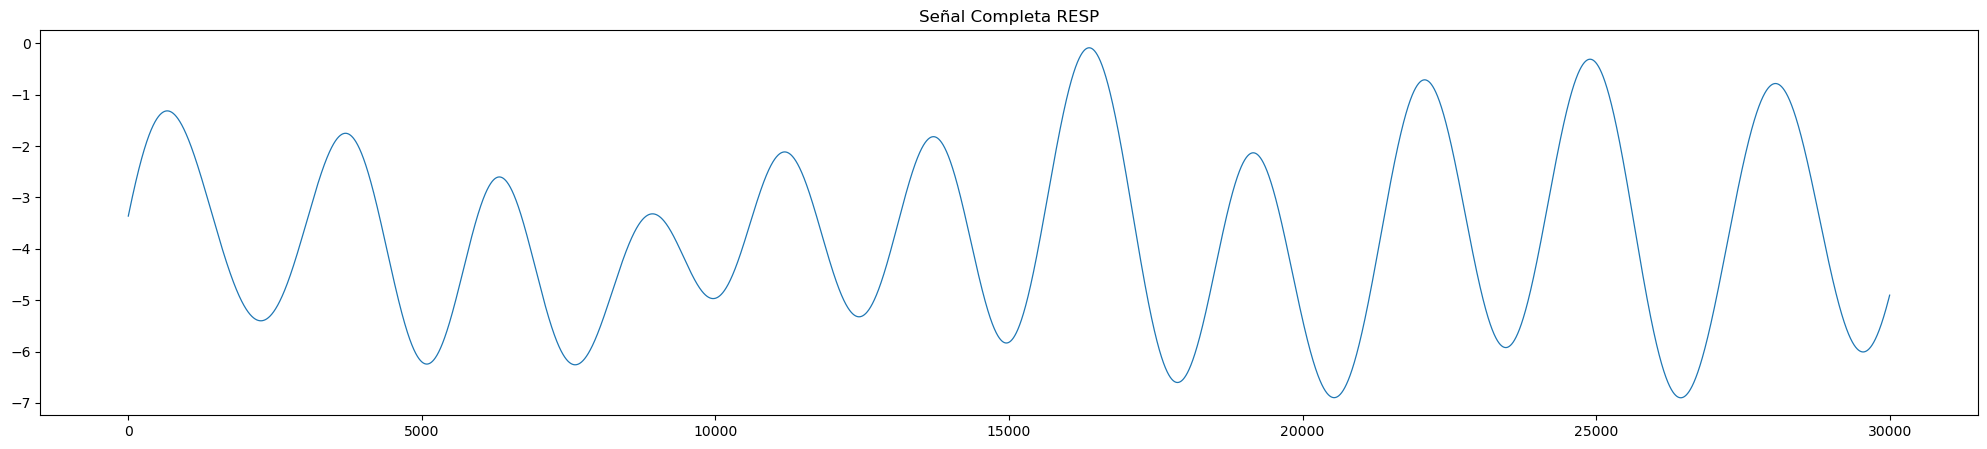

In [272]:
plt.figure(figsize=(25, 5))  # Aumenta el tamaño de la figura
plt.plot(resp_signal[753000:783000], linewidth=0.9)  # Reduce el grosor de la línea
plt.title("Señal Completa RESP")
plt.show()

In [273]:
def compute_respiration_metrics(resp_signal, fs=fs):
    resp_signal = np.array(resp_signal).flatten()
    peaks, _ = scisig.find_peaks(resp_signal, distance=fs * 0.3)
    troughs, _ = scisig.find_peaks(-resp_signal, distance=fs * 0.3)
    
    if len(peaks) < 2 or len(troughs) < 2:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0

    inspiration_durations = np.diff(peaks) / fs
    expiration_durations = np.diff(troughs) / fs

    I_mean = np.mean(inspiration_durations)
    I_std = np.std(inspiration_durations)
    E_mean = np.mean(expiration_durations)
    E_std = np.std(expiration_durations)

    ie_ratio = I_mean / E_mean if E_mean > 0 else 0
    resp_range = np.max(resp_signal) - np.min(resp_signal)
    insp_vol = np.mean(resp_signal[peaks]) - np.mean(resp_signal[troughs])
    resp_rate = len(peaks) / (len(resp_signal) / fs)
    resp_duration = len(resp_signal) / fs

    plt.plot(resp_signal, label="Señal Respiratoria")
    plt.scatter(peaks, resp_signal[peaks], color='red', label="Picos")
    plt.scatter(troughs, resp_signal[troughs], color='blue', label="Valles")
    plt.legend()
    plt.show()

    return I_mean, I_std, E_mean, E_std, ie_ratio, resp_range, insp_vol, resp_rate, resp_duration

In [289]:
def compute_hrv_metrics(ecg_signal, fs):
    ecg_signal = np.array(ecg_signal).flatten()
    
    # Detección de picos R mejorada
    peaks, _ = scisig.find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))

    if len(peaks) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Cálculo de intervalos RR
    rr_intervals = np.diff(peaks) * (1000 / fs)  # Convertir a milisegundos
    rr_intervals = rr_intervals[(rr_intervals > 400) & (rr_intervals < 1500)]  # Filtro fisiológico

    if len(rr_intervals) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Features temporales
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pnn50 = (nn50 / len(rr_intervals)) * 100 if len(rr_intervals) > 0 else np.nan
    rms_hrv = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

    # Cálculo de TINN
    hist, bin_edges = np.histogram(rr_intervals, bins='auto')
    tinn = bin_edges[np.argmax(hist)] if len(hist) > 0 else np.nan

    # Interpolación mejorada
    time_rr = np.cumsum(rr_intervals) / 1000
    time_rr = time_rr - time_rr[0]  # Normalizar inicio en 0

    fs_resample = 4.0  # Frecuencia de resampleo
    time_resampled = np.arange(0, time_rr[-1], 1 / fs_resample)
    interp_func = interp1d(time_rr, rr_intervals, kind="linear", fill_value="extrapolate")
    rr_resampled = interp_func(time_resampled)

    # Análisis espectral (PSD)
    fxx, pxx = scisig.welch(rr_resampled, fs=fs_resample, nperseg=min(len(rr_resampled), 256))

    lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

    lf_mask = (fxx >= lf_band[0]) & (fxx <= lf_band[1])
    hf_mask = (fxx >= hf_band[0]) & (fxx <= hf_band[1])

    lf = np.trapz(pxx[lf_mask], fxx[lf_mask]) if np.any(lf_mask) else np.nan
    hf = np.trapz(pxx[hf_mask], fxx[hf_mask]) if np.any(hf_mask) else np.nan
    lf_hf_ratio = lf / hf if (hf > 0 and not np.isnan(hf)) else np.nan

    sum_f = np.trapz(pxx, fxx)
    rel_f = (lf + hf) / sum_f if sum_f > 0 else np.nan
    lf_norm = (lf / (lf + hf)) * 100 if (lf + hf) > 0 else np.nan
    hf_norm = (hf / (lf + hf)) * 100 if (lf + hf) > 0 else np.nan

    # Visualización - ECG y detección de picos
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_signal, label="ECG", color='gray')
    plt.scatter(peaks, ecg_signal[peaks], color="red", label="Picos R")
    plt.legend()
    plt.title("Detección de Picos R en ECG")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Amplitud")
    plt.show()

    plt.figure()
    plt.plot(time_rr, rr_intervals, "o-", label="Original RR")
    plt.plot(time_resampled, rr_resampled, "x-", label="Interpolado")
    plt.legend()
    plt.title("Interpolación de RR intervals")
    plt.show()

    plt.figure()
    plt.semilogy(fxx, pxx)  # Usa escala logarítmica
    plt.axvspan(0.04, 0.15, color="blue", alpha=0.3, label="LF Band")
    plt.axvspan(0.15, 0.4, color="red", alpha=0.3, label="HF Band")
    plt.legend()
    plt.title("Espectro HRV")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("PSD")
    plt.show()

    return nn50, pnn50, tinn, rms_hrv, lf, hf, lf_hf_ratio, sum_f, rel_f, lf_norm, hf_norm

In [275]:
def compute_eda_metrics(eda_signal, fs):
    eda_signal = np.array(eda_signal).flatten()
    if len(eda_signal) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    scl_mean = np.mean(eda_signal)
    scl_std = np.std(eda_signal)

    # Diferencia de la señal para detectar SCRs
    diff_signal = np.gradient(eda_signal) * 10

    # Detectar SCRs sin normalizar
    scr_peaks, properties = scisig.find_peaks(
        diff_signal, 
        height=np.std(diff_signal) * 1,  # Ajuste del umbral
        distance=fs*0.3  # Permitir detección más frecuente
    )

    scr_mean = np.mean(diff_signal[scr_peaks]) if scr_peaks.size > 0 else np.nan
    scr_std = np.std(diff_signal[scr_peaks]) if scr_peaks.size > 0 else np.nan
    scr_count = len(scr_peaks)
    scr_amp = np.max(np.abs(diff_signal[scr_peaks])) if scr_count > 0 else np.nan
    scr_sum = np.sum(diff_signal[scr_peaks]) if scr_count > 0 else np.nan
    scr_area = np.trapz(diff_signal[scr_peaks]) if scr_count > 1 else 0

    # Correlación de SCL con el tiempo
    time = np.arange(len(eda_signal)) / fs  # Convertir a segundos
    corr_SCL_t = np.corrcoef(time, eda_signal)[0, 1] if len(eda_signal) > 1 else np.nan
    corr_SCL_t = np.nan_to_num(corr_SCL_t)  # Evitar NaNs

    plt.figure(figsize=(10,4))
    plt.plot(diff_signal, label="Diferencia de EDA", alpha=0.7)
    plt.scatter(scr_peaks, diff_signal[scr_peaks], color='red', label="SCRs detectados")
    plt.axhline(np.std(diff_signal) * 0.5, color='gray', linestyle="--", label="Umbral detección")
    plt.xlabel("Tiempo (muestras)")
    plt.ylabel("Diferencia de EDA")
    plt.legend()
    plt.title("Detección de SCRs")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(eda_signal, label="EDA Filtrada")
    plt.scatter(scr_peaks, eda_signal[scr_peaks], color='red', label="SCRs detectados")
    plt.xlabel("Tiempo (muestras)")
    plt.ylabel("EDA (μS)")
    plt.legend()
    plt.title("SCRs detectados en la señal EDA")
    plt.show()

    return scl_mean, scl_std, scr_mean, scr_std, corr_SCL_t, scr_count, scr_amp, scr_sum, scr_area

In [288]:
def compute_hr(ecg_signal, fs, plot=False):
    # Detectar picos R
    peaks, _ = scisig.find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))
    
    # Calcular intervalos RR (diferencias entre picos)
    rr_intervals = np.diff(peaks) / fs  # Convertir a segundos
    
    # Calcular HR (latidos por minuto)
    hr_mean = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan
    hr_std = np.std(60 / rr_intervals) if len(rr_intervals) > 0 else np.nan

    return hr_mean, hr_std

In [287]:
def compute_ppg_features(ppg_signal, fs, plot=False):
    ppg_signal = np.array(ppg_signal).flatten()

    if len(ppg_signal) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Detección de picos en PPG
    peak_indices, _ = scisig.find_peaks(ppg_signal, distance=fs*0.6, prominence=(np.std(ppg_signal) * 0.5, None))


    if len(peak_indices) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    ibi = np.diff(peak_indices) / fs
    hr = 60 / ibi

    hr_mean = np.mean(hr)
    hr_std = np.std(hr)
    rmssd = np.sqrt(np.mean(np.diff(ibi) ** 2))
    sdnn = np.std(ibi)

    # Frecuencia de muestreo para IBI
    fs_ibi = max(1 / np.mean(ibi), 0.5)  # No menor a 0.5 Hz

    # PSD con Welch si hay suficientes puntos
    if len(ibi) > 4:  
        fxx, pxx = scisig.welch(ibi, fs=fs_ibi, nperseg=min(128, len(ibi)))
    else:
        fxx, pxx = np.array([]), np.array([])

    # Cálculo de LF y HF solo si hay valores en la PSD
    if np.sum(pxx) > 0:
        lf_band = (fxx >= 0.04) & (fxx < 0.15)
        hf_band = (fxx >= 0.15) & (fxx < 0.4)

        lf = np.trapz(pxx[lf_band]) if np.any(lf_band) else np.nan
        hf = np.trapz(pxx[hf_band]) if np.any(hf_band) else np.nan
        lf_hf_ratio = lf / hf if hf > 0 else np.nan
    else:
        lf, hf, lf_hf_ratio = np.nan, np.nan, np.nan

    # Características adicionales
    amplitudes = ppg_signal[peak_indices]
    pav_mean = np.mean(amplitudes)
    pav_std = np.std(amplitudes)

    rise_time = np.mean(np.diff(peak_indices[:len(peak_indices)//2]) / fs)
    decay_time = np.mean(np.diff(peak_indices[len(peak_indices)//2:]) / fs)
    # Índice de reflexión (RI)

    plt.figure(figsize=(10, 4))
    plt.plot(ppg_signal, label="ECG", color='gray')
    plt.scatter(peak_indices, ppg_signal[peak_indices], color="red", label="Picos R")
    plt.legend()
    plt.title("Detección de Picos R en ECG")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Amplitud")
    plt.show()
    
    amplitudes = ppg_signal[peak_indices]
    if len(amplitudes) > 1 and amplitudes[0] != 0:
        ri = amplitudes[-1] / amplitudes[0]
    else:
        ri = np.nan

    return hr_mean, hr_std, rmssd, sdnn, lf, hf, lf_hf_ratio, len(peak_indices), rise_time, decay_time, pav_mean, pav_std, ri

In [278]:
def get_slope(signal):
    if len(signal) < 2:  # Evita divisiones por 0 o valores no válidos
        return 0
    
    # Convertir a pandas.Series si es necesario
    if not isinstance(signal, pd.Series):
        signal = pd.Series(signal)

    resu = (signal.iloc[-1] - signal.iloc[0]) / (len(signal) - 1)  # Evita dividir entre len(signal)

    # Convertir a escalar si es un array
    if isinstance(resu, np.ndarray):
        resu = resu.flatten()[0]
    
    return resu

In [279]:
def compute_features(data_dict, fs_dict):

    print(data_dict)

    for key, values in data_dict.items():
        print(f"\n🔍 Revisando {key}: {len(values)} muestras, NaNs: {np.isnan(values).sum()}")
        if len(values) == 0:
            print(f"❌ {key} está completamente vacío dentro de compute_features()")
        if np.isnan(values).all():
            print(f"⚠️ {key} tiene solo NaNs en compute_features()")

    feature_dict = {}

    # ECG y BVP

    ecg_signal = data_dict['ECG']
    eda_signal = data_dict['EDA']
    ppg_signal = data_dict['PPG']
    resp_signal = data_dict['RESP']

    try:
        hr_mean, hr_std = compute_hr(ecg_signal, fs_dict['ECG'])

    except Exception as e:
        print(f"Error en compute_hr: {e}")

    feature_dict['HR_mean'] = hr_mean
    feature_dict['HR_std'] = hr_std

    try:
        nn50, pNN50, tinn, rmsHRV, lf, hf, lf_hf, sum_f, rel_f, lf_norm, hf_norm = compute_hrv_metrics(ecg_signal, fs_dict['ECG'])

    except Exception as e:
        print(f"Error en compute_hr: {e}")
    
    feature_dict.update({
        'NN50': nn50, 'pNN50': pNN50, 'TINN': tinn, 
        'rmsHRV': rmsHRV, 'LF': lf, 'HF': hf, 'LF_HF': lf_hf,
        'sum_f': sum_f, 'rel_f': rel_f, 'LF_norm': lf_norm, 'HF_norm': hf_norm
    })

    print("ecg calculado")

    try:
        hr_mean, hr_std, rmssd, sdnn, lf, hf, lf_hf, num_beats, rise_time, decay_time, pav_mean, pav_std, ri = compute_ppg_features(ppg_signal, fs_dict['PPG'])

    except Exception as e:
        print(f"Error en compute_hr: {e}")

    feature_dict.update({
        'PPG_HR_mean': hr_mean, 'PPG_HR_std': hr_std, 'PPG_RMSSD': rmssd, 'PPG_SDNN': sdnn,
        'PPG_LF': lf, 'PPG_HF': hf, 'PPG_LF_HF': lf_hf, 'PPG_num_beats': num_beats,
        'PPG_RiseTime': rise_time, 'PPG_DecayTime': decay_time, 
        'PPG_PAV_mean': pav_mean, 'PPG_PAV_std': pav_std, 'PPG_RI': ri
    })

    print("ppg calculado")

    feature_dict.update({
        'EDA_mean': np.mean(eda_signal), 'EDA_std': np.std(eda_signal),
        'EDA_min': np.min(eda_signal), 'EDA_max': np.max(eda_signal),
        'EDA_range': np.max(eda_signal) - np.min(eda_signal), 'EDA_slope': get_slope(eda_signal)
    })


    try:
        scl_mean, scl_std, scr_mean, scr_std, corr_scl_t, scr_count, scr_amp, scr_sum, scr_area = compute_eda_metrics(eda_signal, fs_dict['EDA'])

    except Exception as e:
        print(f"Error en compute_hr: {e}")

    feature_dict.update({
        'scl_mean': scl_mean, 'scl_std': scl_std, 'scr_mean': scr_mean, 'scr_std': scr_std,
        'corr_scl_t': corr_scl_t, 'scr_count': scr_count, 'scr_amp': scr_amp,
        'scr_sum': scr_sum, 'scr_area': scr_area
    })

    print("eda calculado")

    feature_dict.update({
        'Resp_mean': np.mean(resp_signal), 'Resp_std': np.std(resp_signal),
    })

    try:
        I_mean, I_std, E_mean, E_std, ie_ratio, resp_range, insp_vol, resp_rate, resp_duration = compute_respiration_metrics(resp_signal, fs_dict['RESP'])
    except Exception as e:
        print(f"Error en compute_hr: {e}")  
              
    feature_dict.update({
        'Resp_I_mean': I_mean, 'Resp_I_std': I_std, 'Resp_E_mean': E_mean, 'Resp_E_std': E_std,
        'Resp_IE_ratio': ie_ratio, 'Resp_range': resp_range, 'Resp_insp_vol': insp_vol,
        'Resp_rate': resp_rate, 'Resp_duration': resp_duration
    })

    print("resp calculado")

    # Convertir a DataFrame con solo una fila
    df = pd.DataFrame([feature_dict])

    df["EDA_slope"] = df["EDA_slope"].apply(lambda x: x[0] if isinstance(x, list) else x)

    return df

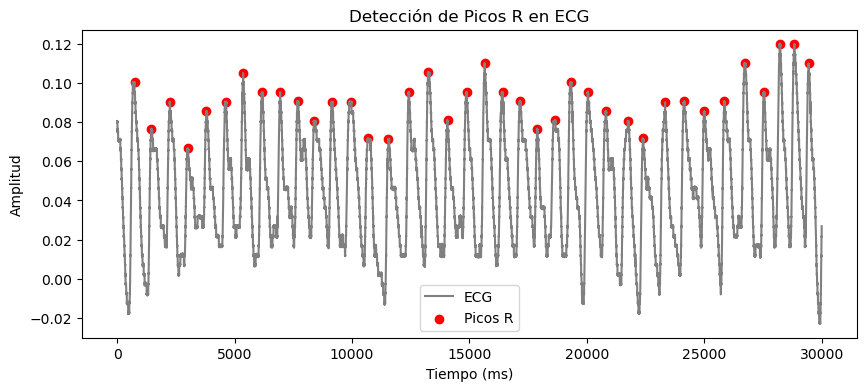

(78.23798228685777, 8.656150991269136, 0.11137586512944954, 0.08275752466676399, 0.04017524855651678, 0.022383952533257787, 1.794823702240474, 38, 0.7859444444444446, 0.7666111111111111, 0.09147239210526317, 0.012659136083464561, 1.0942202922223438)


In [290]:
c = compute_ppg_features(df['PPG'][1713750:1743750], fs)
print(c)

In [291]:
c = compute_hr(ecg_signal[1713750:1743750], fs)
print(c)

(77.54310784613816, 7.4495358604533735)


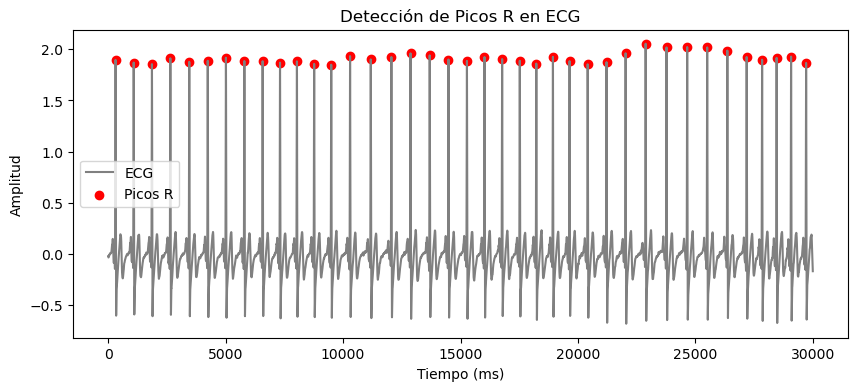

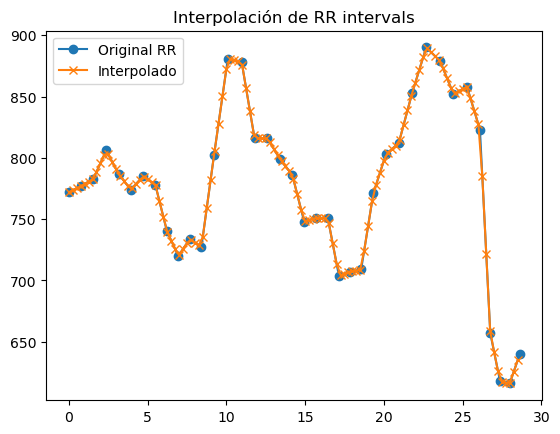

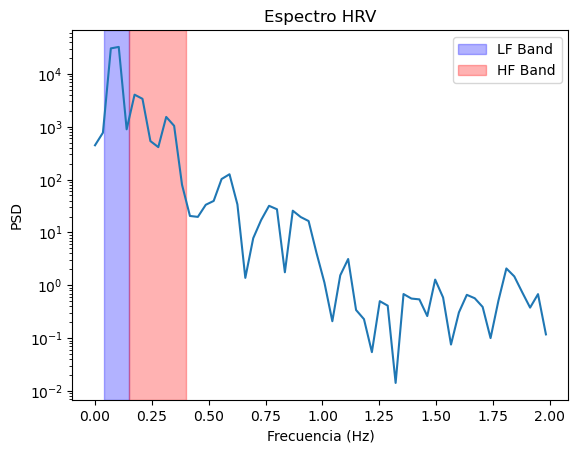

(5, 13.157894736842104, 772.5714285714286, 41.263163337881025, 1664.0316127128212, 310.80400282636595, 5.353958113732695, 2641.8829128546386, 0.7475106508052298, 84.26177853079142, 15.738221469208591)


In [292]:
c = compute_hrv_metrics(ecg_signal[1713750:1743750], fs)
print(c)

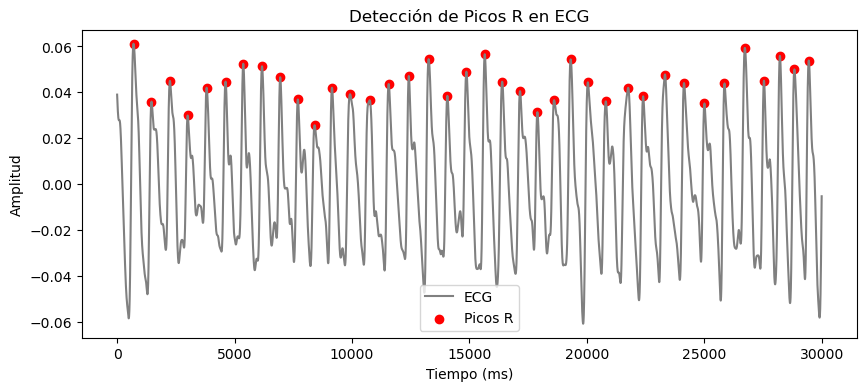

(77.94625466249369, 7.744423091078205, 0.09080458260584771, 0.07419293546392294, 0.037571503756493436, 0.012264323342098699, 3.0634795502761194, 38, 0.7872777777777777, 0.7665000000000001, 0.04424181576883923, 0.008159829804197376, 0.8804425607599755)


In [293]:
c = compute_ppg_features(ppg_signal[1713750:1743750], fs)
print(c)

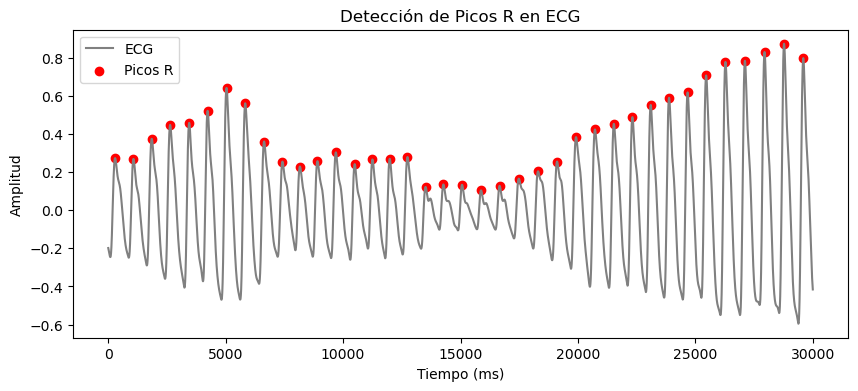

(75.83950359967574, 2.3909080172520314, 0.019048913646481556, 0.02458452422284588, 0.005697979949943431, 0.0038386673834982267, 1.4843640723960796, 38, 0.776611111111111, 0.8071666666666667, 0.4094454567417627, 0.22124691338618185, 2.918474635489116)


In [294]:
c = compute_ppg_features(ppg_signal[1000000:1030000], fs)
print(c)

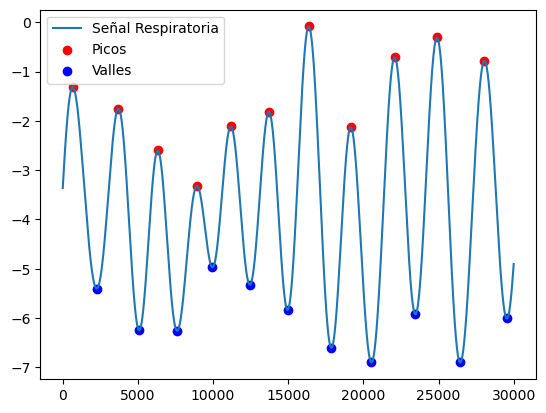

(2.7392, 0.25012548850527005, 2.7289000000000003, 0.24142760819757128, 1.0037744145992888, 6.814653016986301, 4.493875817579421, 0.36666666666666664, 30.0)


In [295]:
c = compute_respiration_metrics(resp_signal[753000:783000], fs)
print(c)

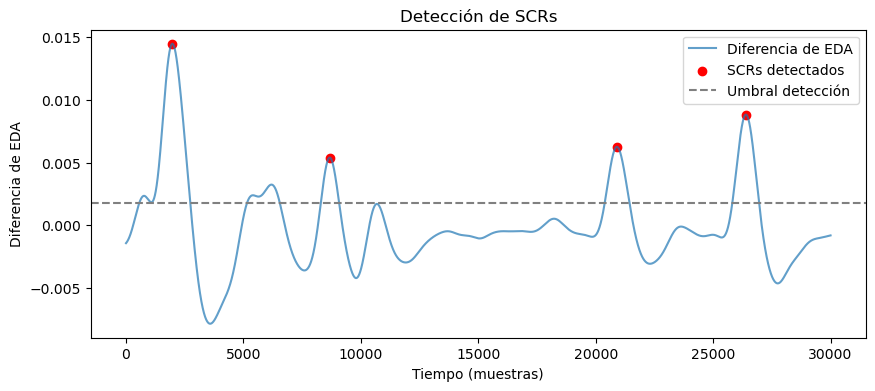

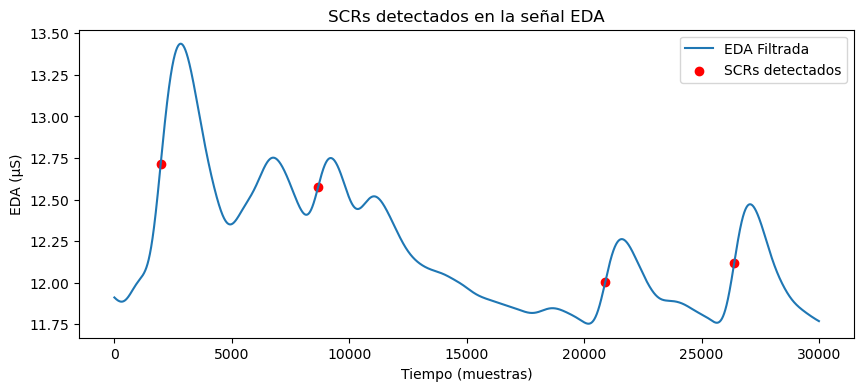

(12.212685021008104, 0.3928985996804202, 0.008747358131924177, 0.0035440522395914663, -0.6199181051434776, 4, 0.014484021884575426, 0.03498943252769671, 0.02333019425087901)


In [296]:
c = compute_eda_metrics(eda_signal[753000:783000], fs)
print(c)

In [130]:
print(np.mean(ecg_signal[1610250:1640250]))

0.0002791680051456608


In [131]:
c = get_slope(eda_signal[1610250:1640250])
print(c)

-8.044442646069955e-05


In [132]:
data = df
data['ECG'] = ecg_signal
data['EDA'] = eda_signal
data['RESP'] = resp_signal
data['PPG'] = ppg_signal
labels = df['label']
data = data.drop(columns=['time', 'label'])

print(data.head())

       RESP       PPG       ECG       EDA
0 -4.996724 -0.350726  0.160669  8.328556
1 -4.994672 -0.351155  0.162662  8.328515
2 -4.992616 -0.351572  0.164579  8.328474
3 -4.990557 -0.351978  0.166362  8.328433
4 -4.988495 -0.352371  0.167960  8.328392


In [133]:
fs_dict = {'PPG': 1000, 'EDA': 1000, 'RESP': 1000, 'ECG': 1000, 'label': 1000}

In [208]:
window_data = {key: val[1713750:1743750] for key, val in data.items()}
print(window_data)

{'RESP': 1713750   -2.735733
1713751   -2.734715
1713752   -2.733686
1713753   -2.732647
1713754   -2.731597
             ...   
1743745   -0.999028
1743746   -0.997488
1743747   -0.995952
1743748   -0.994419
1743749   -0.992889
Name: RESP, Length: 30000, dtype: float64, 'PPG': 1713750   -0.052592
1713751   -0.054714
1713752   -0.056843
1713753   -0.058980
1713754   -0.061125
             ...   
1743745   -0.606235
1743746   -0.606366
1743747   -0.606480
1743748   -0.606576
1743749   -0.606653
Name: PPG, Length: 30000, dtype: float64, 'ECG': 1713750    0.042378
1713751    0.040943
1713752    0.039429
1713753    0.037835
1713754    0.036158
             ...   
1743745    0.303587
1743746    0.304464
1743747    0.305168
1743748    0.305695
1743749    0.306048
Name: ECG, Length: 30000, dtype: float64, 'EDA': 1713750    16.764907
1713751    16.764737
1713752    16.764567
1713753    16.764397
1713754    16.764227
             ...    
1743745    14.785551
1743746    14.793178
1743747    14.8

{'RESP': 1713750   -2.735733
1713751   -2.734715
1713752   -2.733686
1713753   -2.732647
1713754   -2.731597
             ...   
1743745   -0.999028
1743746   -0.997488
1743747   -0.995952
1743748   -0.994419
1743749   -0.992889
Name: RESP, Length: 30000, dtype: float64, 'PPG': 1713750   -0.052592
1713751   -0.054714
1713752   -0.056843
1713753   -0.058980
1713754   -0.061125
             ...   
1743745   -0.606235
1743746   -0.606366
1743747   -0.606480
1743748   -0.606576
1743749   -0.606653
Name: PPG, Length: 30000, dtype: float64, 'ECG': 1713750    0.042378
1713751    0.040943
1713752    0.039429
1713753    0.037835
1713754    0.036158
             ...   
1743745    0.303587
1743746    0.304464
1743747    0.305168
1743748    0.305695
1743749    0.306048
Name: ECG, Length: 30000, dtype: float64, 'EDA': 1713750    16.764907
1713751    16.764737
1713752    16.764567
1713753    16.764397
1713754    16.764227
             ...    
1743745    14.785551
1743746    14.793178
1743747    14.8

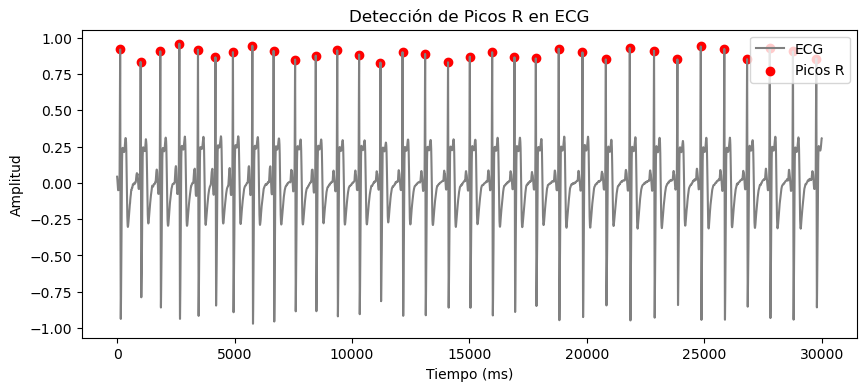

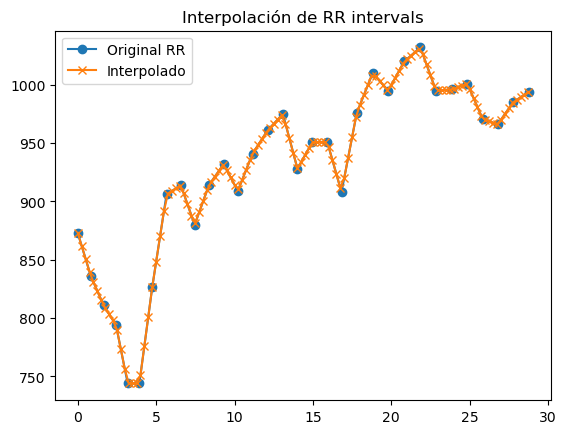

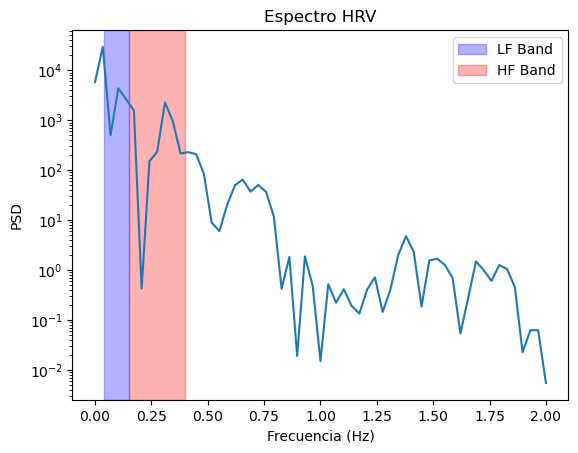

ecg calculado


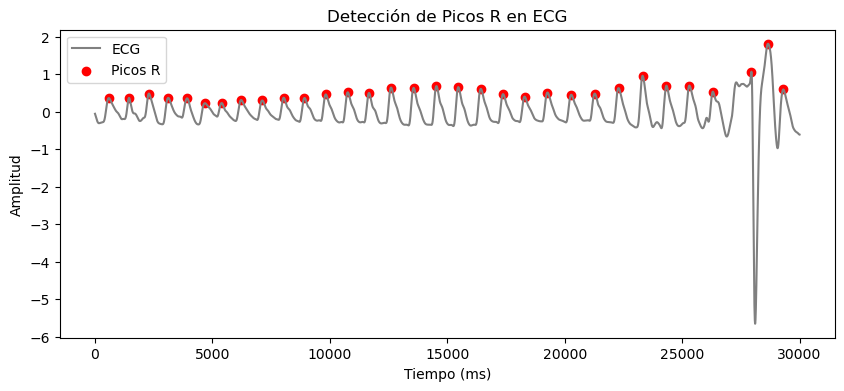

ppg calculado


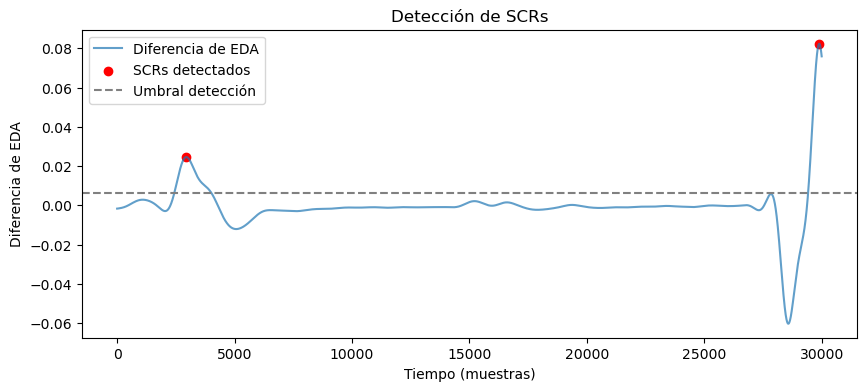

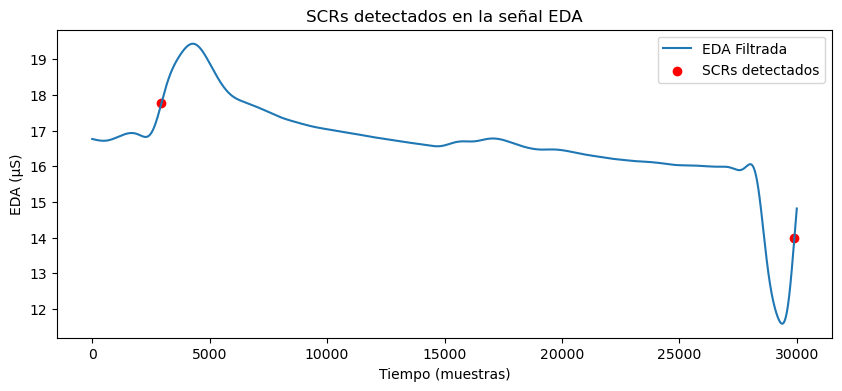

eda calculado


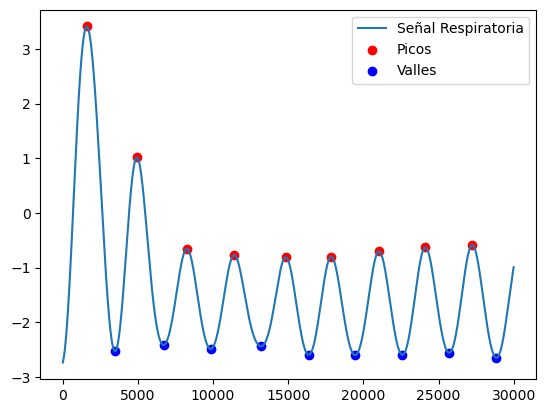

resp calculado


In [297]:
a = compute_features(window_data, fs_dict)

In [210]:
print(a)

     HR_mean    HR_std  NN50  pNN50   TINN     rmsHRV          LF         HF  \
0  64.777328  5.908481     3  9.375  984.0  34.494039  204.493792  156.09382   

     LF_HF        sum_f  ...  Resp_std  Resp_I_mean  Resp_I_std  Resp_E_mean  \
0  1.31007  1588.807047  ...   1.23341     3.205875    0.129628     3.171375   

   Resp_E_std  Resp_IE_ratio  Resp_range  Resp_insp_vol  Resp_rate  \
0    0.076161       1.010879    6.147494       2.483263        0.3   

   Resp_duration  
0           30.0  

[1 rows x 52 columns]


In [ ]:
for start in range(0, len(labels) - 30000 + 1, 750):
    end = start + 30000
    print(f"\nVentana {start} - {end}")

    # Extraer la ventana de cada señal
    window_data = {}
    for key, val in data.items():
        if end > len(val):
            print(f"⚠️ Advertencia: {key} solo tiene {len(val)} muestras, pero se intentó acceder hasta {end}.")
            break  # Saltar esta ventana
        window_data[key] = val[start:end]


    # Verificar si hay NaNs y contarlos
    nan_counts = {key: np.isnan(v).sum() for key, v in window_data.items()}
    total_nans = sum(nan_counts.values())


    # Verificar tamaños de cada señal en esta ventana
    for key, values in window_data.items():
        print(f"{key}: {len(values)} muestras, NaNs: {np.isnan(values).sum()}")

    # Mostrar el primer y último valor de cada señal en la ventana
    for key, values in window_data.items():
        print(f"{key}: Primer valor={values.iloc[0] if not values.empty else 'VACÍO'}, Último valor={values.iloc[-1] if not values.empty else 'VACÍO'}")

    print("✅ Datos verificados, llamando a compute_features()")
    features_df = compute_features(window_data, fs_dict)



Ventana 0 - 30000
RESP: 30000 muestras, NaNs: 0
PPG: 30000 muestras, NaNs: 0
ECG: 30000 muestras, NaNs: 0
EDA: 30000 muestras, NaNs: 0
RESP: Primer valor=-4.996723253427099, Último valor=-2.4156642278178473
PPG: Primer valor=-0.3507261362761459, Último valor=0.003951634556436301
ECG: Primer valor=0.16078947710547326, Último valor=0.020276140715301597
EDA: Primer valor=8.328556596407617, Último valor=8.831826004217273
✅ Datos verificados, llamando a compute_features()

🔍 Revisando RESP: 30000 muestras, NaNs: 0

🔍 Revisando PPG: 30000 muestras, NaNs: 0

🔍 Revisando ECG: 30000 muestras, NaNs: 0

🔍 Revisando EDA: 30000 muestras, NaNs: 0
ecg calculado
ppg calculado
eda calculado
resp calculado
Memoria usada: 41.5%

Ventana 750 - 30750
RESP: 30000 muestras, NaNs: 0
PPG: 30000 muestras, NaNs: 0
ECG: 30000 muestras, NaNs: 0
EDA: 30000 muestras, NaNs: 0
RESP: Primer valor=-3.1838955731998606, Último valor=-1.7581875039909134
PPG: Primer valor=-0.48406292774271226, Último valor=0.75231857124369